# Notebook: Merging Lab Data with Well Log Data 

**Description:** Workflow to merge processed lab data, well log data, and geological formation information into a single dataset for further analysis.

---

## Table of Contents

1. [Introduction](#1-introduction)
2. [Setup](#2-setup)
3. [Step 1: Load Datasets](#3-step-1-load-datasets)
4. [Step 2: Merge Lab and Well Log Data](#4-step-2-merge-lab-and-well-log-data)
5. [Step 3: Add Geological Formation Data](#5-step-3-add-geological-formation-data)
6. [Step 4: Visualize Merged Data with Formations](#6-step-4-visualize-merged-data-with-formations)
7. [Step 5: Save Final Dataset](#7-step-5-save-final-dataset)

---

## 1. Introduction

This notebook focuses on merging processed lab data, well log data, and geological formation/member data into a single, unified dataset. The goal is to ensure the dataset is structured and ready for analysis and machine learning applications. The workflow includes:

1. **Loading processed datasets**: Load cleaned lab data, standardized well log data, and geological formation information.
2. **Merging datasets**: Combine lab and well log data using depth and well identifiers.
3. **Adding geological formation/member information**: Map formation/member names to the dataset based on depth intervals.
4. **Visualizing merged data**: Inspect property distributions and formation layers.
5. **Saving the final dataset**: Export the unified dataset for downstream analysis.

---

## 2. Setup

Import necessary libraries and modules.

In [1]:
import numpy as np
import pandas as pd

import sys
sys.path.append("../.")

from geothermal_prediction.utils import save_to_csv
from geothermal_prediction.visualization import  plot_properties_with_formation


---

## 3. Step 1: Load Datasets
Load the processed lab data, well log data, and raw geological formation/member data.

In [2]:
# Load processed lab data
lab_data = pd.read_csv('../data/processed/final_lab_data.csv')

# Load processed well log data
log_data = pd.read_csv('../data/processed/final_well_logs.csv')

# Load geological  formation data
formation_data = pd.read_csv('../data/raw/lab/core_intervals.csv')

# Rename columns in formation data for clarity
formation_data.rename(columns={
    'well': 'Well_ID', 
    'Top(m)': 'Formation_Top',
    'Bottom(m)': 'Formation_Bottom',
    'formation/member': 'Formation_Member'
}, inplace=True)

---

## 4. Step 2: Merge Lab and Well Log Data
Combine the lab and well log data into a single DataFrame. Add specific prefixes (`_lab`, `_log`) to differentiate columns.

In [3]:
# Add prefixes to distinguish columns
lab_columns = ['Density', 'Porosity', 'Vp', 'Vs', 'Acoustic_Imp', 'Th_Cond', 'Th_Diff']
log_columns = ['Gamma_Ray', 'Bulk_Density', 'Porosity', 'Sonic_Log']

lab_data.rename(columns={col: f'{col}_lab' for col in lab_columns}, inplace=True)
log_data.rename(columns={col: f'{col}_log' for col in log_columns}, inplace=True)


In [4]:
# Merge the lab and log data
merged_data = pd.merge(
    lab_data, 
    log_data, 
    on=['Well_ID', 'Depth'], 
    how='outer'  # Use outer join to preserve all data
)

# Display Merge data
merged_data.head()

,Well_ID,Depth,Density_lab,Porosity_lab,Vp_lab,Vs_lab,Acoustic_Imp_lab,Th_Cond_lab,Th_Diff_lab,Gamma_Ray_log,Bulk_Density_log,Porosity_log,Sonic_Log_log
0,E18-05,82.8999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.651695,NaN,NaN,NaN
1,E18-05,82.9999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.013695,NaN,NaN,NaN
2,E18-05,83.0999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.670784,NaN,NaN,NaN
3,E18-05,83.1999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.615822,NaN,NaN,NaN
4,E18-05,83.2999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.945969,NaN,NaN,NaN


---

## 5. Step 3: Add Geological Formation Data
Efficiently map formation/member information to the merged dataset using depth intervals.

In [5]:
# Sort formation data by Well_ID and Formation_Top for faster filtering
formation_data.sort_values(by=['Well_ID', 'Formation_Top'], inplace=True)

# Initialize the Formation column with a placeholder instead of np.nan
merged_data['Formation'] = 'Unknown_Formation'

# Efficiently map formation/member using a vectorized approach
for well_id in merged_data['Well_ID'].unique():
    # Get the subset of merged_data and formation_data for the current well
    well_logs = merged_data[merged_data['Well_ID'] == well_id]
    well_formations = formation_data[formation_data['Well_ID'] == well_id]

    # Perform mapping for the specific well
    if not well_formations.empty:
        # Initialize the Series with the default placeholder
        well_formation_series = pd.Series('Unknown_Formation', index=well_logs.index, dtype="string")

        for _, formation_row in well_formations.iterrows():
            # Find matching depths for the current formation
            within_range = (
                (well_logs['Depth'] >= formation_row['Formation_Top']) &
                (well_logs['Depth'] <= formation_row['Formation_Bottom'])
            )
            # Assign the formation member to the matching rows
            well_formation_series[within_range] = formation_row['Formation_Member']

        # Update the Formation column in the main dataset
        merged_data.loc[well_logs.index, 'Formation'] = well_formation_series

# Display Merge data
merged_data.head()

,Well_ID,Depth,Density_lab,Porosity_lab,Vp_lab,Vs_lab,Acoustic_Imp_lab,Th_Cond_lab,Th_Diff_lab,Gamma_Ray_log,Bulk_Density_log,Porosity_log,Sonic_Log_log,Formation
0,E18-05,82.8999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.651695,NaN,NaN,NaN,Unknown_Formation
1,E18-05,82.9999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.013695,NaN,NaN,NaN,Unknown_Formation
2,E18-05,83.0999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.670784,NaN,NaN,NaN,Unknown_Formation
3,E18-05,83.1999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.615822,NaN,NaN,NaN,Unknown_Formation
4,E18-05,83.2999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.945969,NaN,NaN,NaN,Unknown_Formation


---

## 6. Step 4: Visualize Merged Data with Formations

Plot properties for each well, including formation layers.

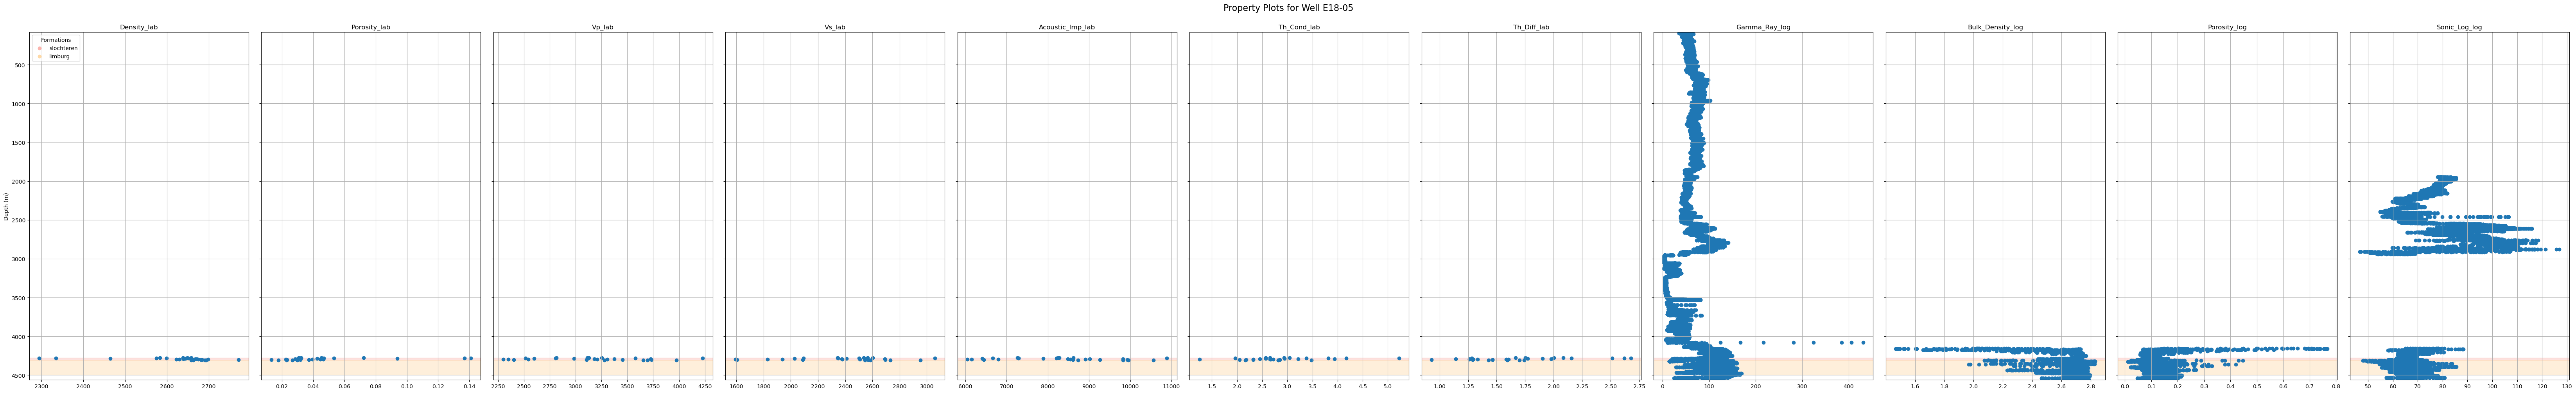

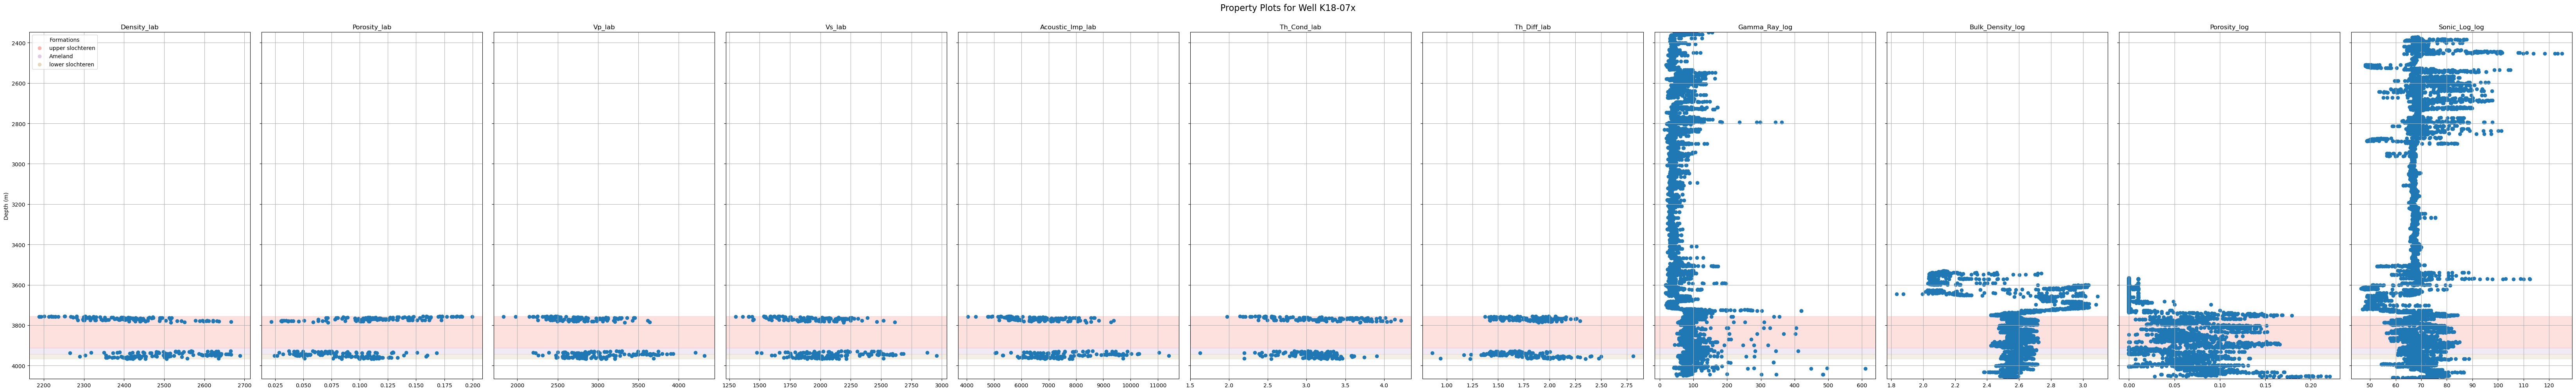

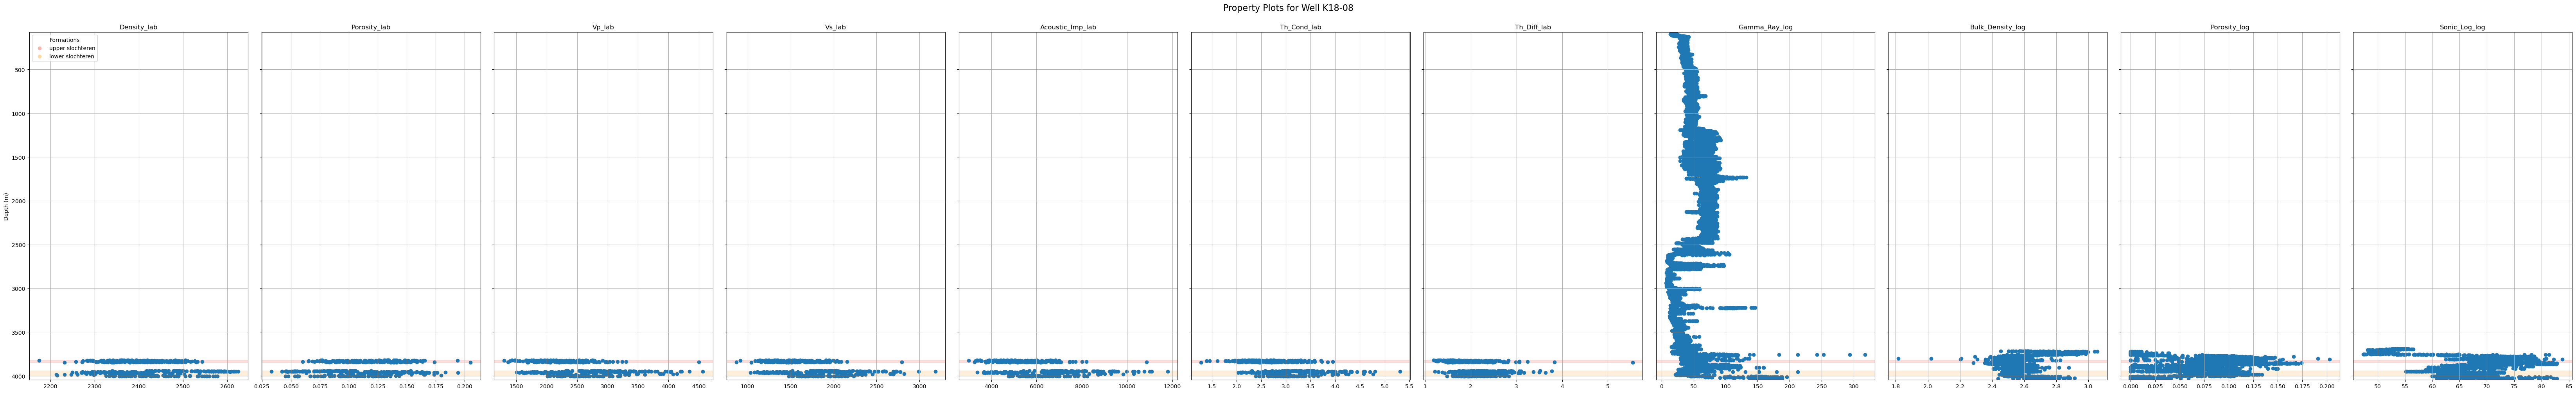

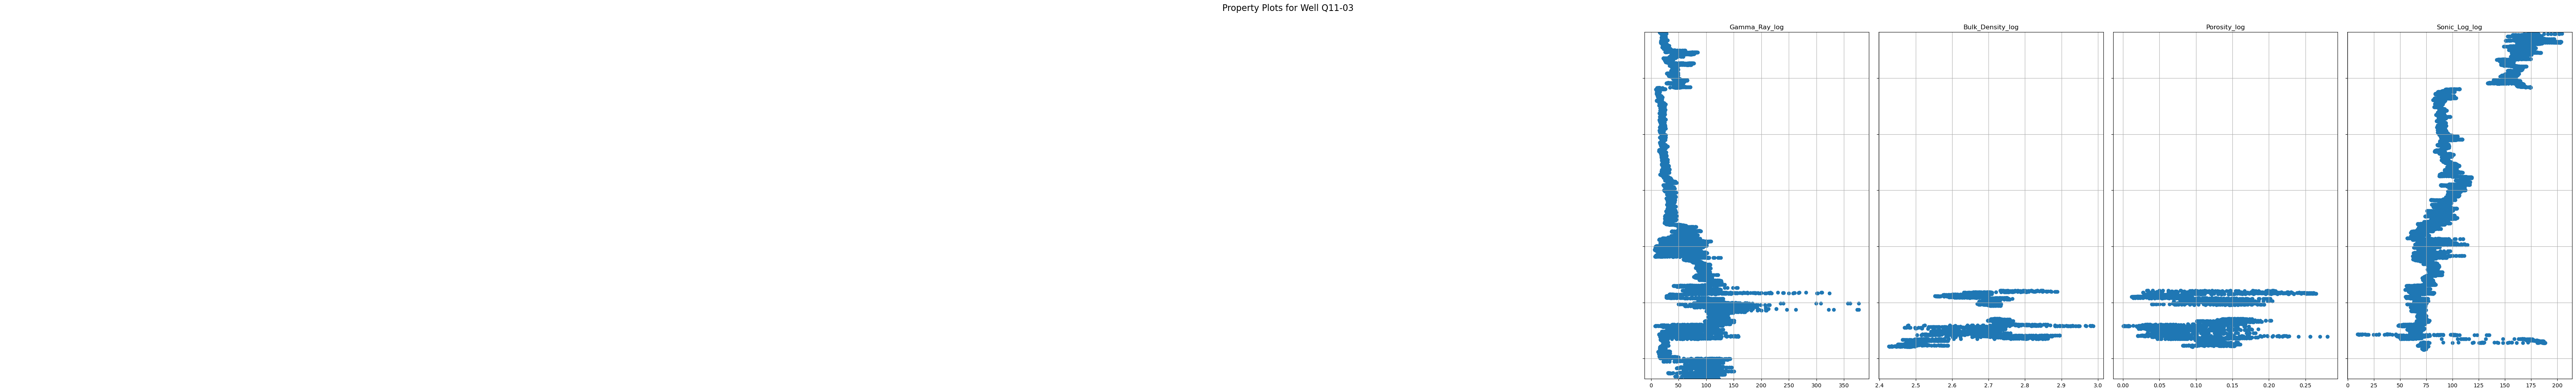

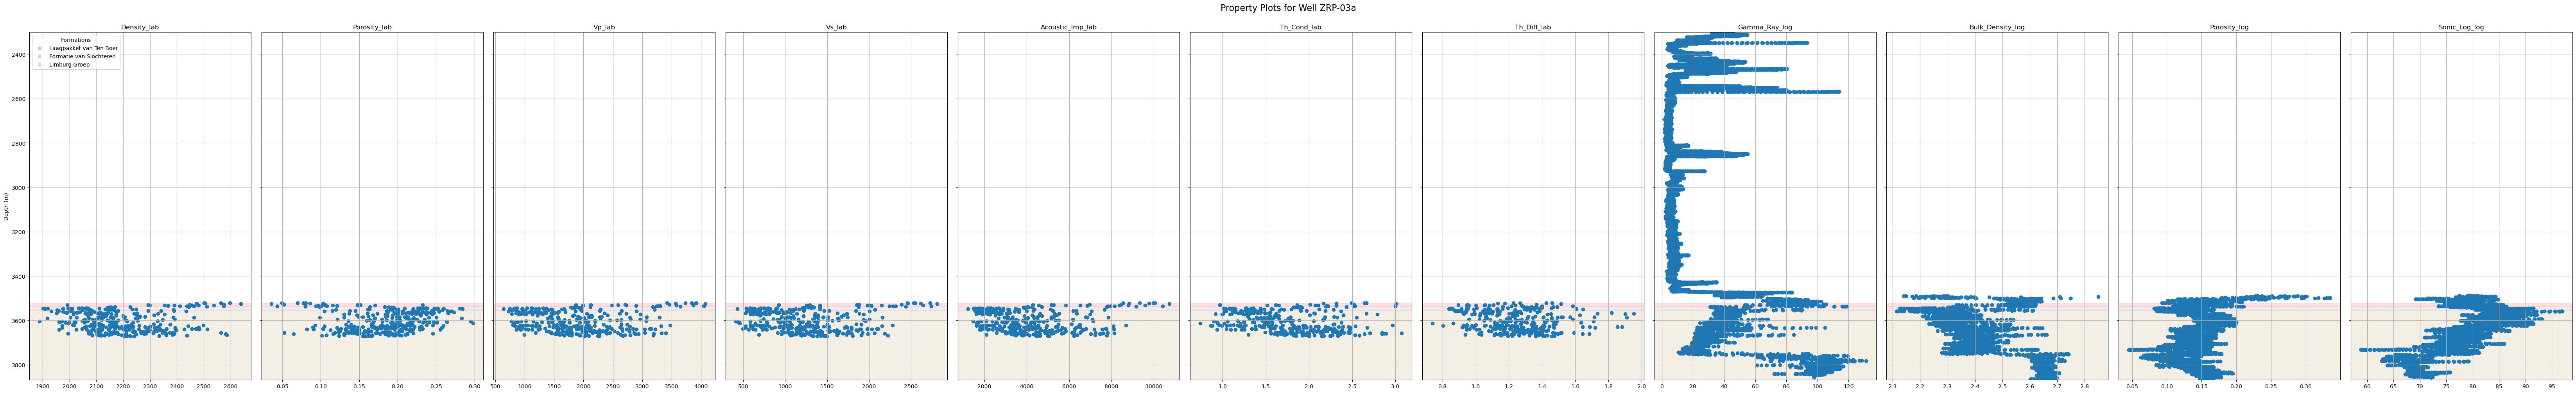

In [6]:
for well_name in merged_data['Well_ID'].unique():
    plot_properties_with_formation(
        dataset=merged_data, 
        well_name=well_name, 
        property_columns=['Density_lab', 'Porosity_lab', 'Vp_lab', 'Vs_lab', 'Acoustic_Imp_lab', 
                          'Th_Cond_lab', 'Th_Diff_lab', 
                          'Gamma_Ray_log', 'Bulk_Density_log', 'Porosity_log', 'Sonic_Log_log'], 
        formation_column='Formation'
    )

---

## 7. Step 5: Save Final Dataset

Save the final merged dataset to the `data/processed/` folder for downstream analysis.

In [7]:
# Drop well Q11-03 from the merged_data DataFrame
merged_data = merged_data[merged_data['Well_ID'] != 'Q11-03']

# Reset the index after dropping the well (optional)
merged_data.reset_index(drop=True, inplace=True)

In [8]:
# Save the final merged dataset
save_to_csv(merged_data, 'final_merged_data', folder='data/processed/')

File saved successfully
